## Stormer-Verlet time integration for the Von Karman plate model

In [1]:
import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
import time

In [2]:
params = loadmat("../matlab/param/Test_NL_Fullclamp_1.mat")

FileNotFoundError: [Errno 2] No such file or directory: '../matlab/vkplate/param/Test_NL_Fullclamp_1.mat'

In [3]:
print(params.keys())

dict_keys(['__header__', '__version__', '__globals__', 'BCsPhi', 'BCsPsi', 'E', 'Hv', 'Lx', 'Ly', 'Lz', 'Nmodes', 'Nx', 'Ny', 'Om', 'Om2', 'Phi', 'Psi', 'X', 'Y', 'h', 'nu', 'rho', 'zetafourth'])


In [4]:
# fmt: off
n_modes = params["Nmodes"].reshape(-1)[0]
Nx = params["Nx"].reshape(-1)[0]                # Number of grid points in the x direction
Ny = params["Ny"].reshape(-1)[0]                # Number of grid points in the y direction
zetafourth = params["zetafourth"].reshape(-1)   # Eigenvalues of the stress (n_modes, 1)
Hv = params["Hv"]                               # Coupling coefficients (n_modes, n_modes, n_modes)
E = params["E"].reshape(-1)[0]                  # young modulus scalar
Lz = params["Lz"].reshape(-1)[0]                # thickness scalar
rho = params["rho"].reshape(-1)[0]              # density scalar
nu = params["nu"].reshape(-1)[0]                # Poisson ratio scalar
eta = np.zeros((n_modes,))                      # Modal stress vector at n (n_modes, 1)
nlsv = np.zeros((n_modes,))                     # Nonlinear term of Stormer Verlet
# fmt: on

# declared parameters
sr = 44100  # sample rate
os = 2  # oversampling factor
T = 0.01  # duration

# derived parameters
D = E * Lz**3 / 12 / (1 - nu**2)
k = 1 / sr / os  # time step
Ts = int(T // k)  # Number of time grid points

print(f"Number of modes: {n_modes}")
print(f"Number of grid points in the x direction: {Nx}")
print(f"Number of grid points in the y direction: {Ny}")
print(f"Number of time grid points: {Ts}")

Number of modes: 100
Number of grid points in the x direction: 630
Number of grid points in the y direction: 1260
Number of time grid points: 882



$$
\begin{aligned}
\mathbf{A} &= \frac{\xi \omega}{2k} + \mathbf{I} \\
\mathbf{B} &= 2 \mathbf{I} - k^2 \omega^2 \\
\mathbf{Y} &= \frac{\xi \omega}{2k} - \mathbf{I} \\
\end{aligned}
$$


In [5]:
Omega = params["Om"].reshape(-1)
I = np.eye(n_modes)
xi = 0.005
A_inv = (0.5 * k * xi * Omega + np.ones(n_modes)) ** -1
# A_inv = np.diag(A_inv)  # Damping term (n_modes, n_modes)

print(f"Omega[0] {Omega[0]}")
print(f"Omega[1] {Omega[1]}")

print(f"A_inv[0] {A_inv[0]}")
print(f"A_inv[1] {A_inv[1]}")


B = 2 * np.ones(n_modes) - k**2 * Omega**2  # Stiffness term (n_modes, n_modes)
B = np.diag(B)

C = 0.5 * k * xi * Omega - np.ones(n_modes)  # Damping term in the Stormer-Verlet scheme
C = np.diag(C)

Omega[0] 103.29831017399749
Omega[1] 133.76223501832405
A_inv[0] 0.9999970720519353
A_inv[1] 0.9999962085678041


### Force

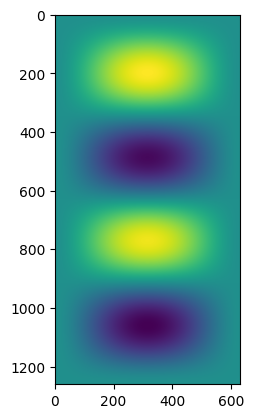

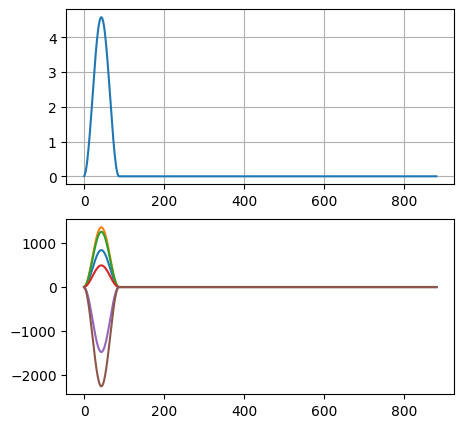

In [6]:
Phi = params["Phi"]

c0 = D / (rho * Lz)  # wave speed
T0 = 0.0005  # time duration of the excitation
Thw = 0.0005  # time duration of the hammer impact

fext = np.zeros((Ts,))
for n in range(1, Ts + 1):
    if np.abs(n * k - T0) < Thw:
        fext[n - 1] = 1 * c0 * (1 + np.cos(np.pi * (n * k - T0) / Thw))
# fext = fext[:, None]

# important to unravel using column order!
# Phi_reshaped has shape (Ny+1, Nx+1, n_modes)
Phi_reshaped = np.reshape(Phi, shape=(Ny + 1, Nx + 1, -1), order="F")
tmp = Phi_reshaped[:, :, 0]
val = tmp[tmp.shape[0] // 4 - 1, tmp.shape[1] // 4 - 1]

modal_excitation = np.zeros((n_modes, Ts))
for m in range(n_modes):
    # modal_shape is the eigenfunction of the plate for mode m
    modal_shape = Phi_reshaped[..., m]
    modal_excitation[m] = (
        200
        * fext
        * modal_shape[modal_shape.shape[0] // 4 - 1, modal_shape.shape[1] // 4 - 1]
    )

fig, ax = plt.subplots()
ax.imshow(Phi_reshaped[:, :, 3])

fig, ax = plt.subplots(2, 1, figsize=(5, 5))
ax[0].plot(fext[:1000])
ax[0].grid()
_ = ax[1].plot(modal_excitation[:6, :1000].T)

## Main Loop

$$
\begin{aligned}
\eta_k &=  - \frac{E Lz}{2 \zeta_k^4}  \sum_{i, j}^{N_{\Phi}} H_{k, i, j}  q_i q_j \\
nl_i &=  \sum_{j, k}^{N_{\Phi}} H_{k, i, j} q_j \eta_k \\
\mathbf{q}^{n+1} &= \mathbf{A}^{-1} (\mathbf{B} \mathbf{q^n} + \mathbf{C} \mathbf{q}^{n-1} + \frac{k^2}{\rho Lz} \mathbf{nl}^n + k^2 \mathbf{p}^n)
\end{aligned}
$$

In [12]:
q = np.ones((n_modes,)) * 0.001  # modal displacement vector at n (n_modes, 1)
for m in range(n_modes):
    eta[m] = -(
        (E * Lz)
        / (2.0 * zetafourth[m])
        * np.einsum("ij, i, j ->", Hv[:, :, m], q, q, optimize=True)
    )

# calculate the nl term
for m in range(n_modes):
    nlsv[m] = np.einsum("ij, i, j ->", Hv[m, :, :], q, eta, optimize=True)


print(f"eta[0] {eta[0]}")

eta[0] -13125.554393188188


In [8]:
# fmt: off
eta = np.zeros((n_modes,))           # Modal stress vector at n (n_modes, 1)
q = np.zeros((n_modes,))             # Modal displacement vector at n (n_modes, 1)
q_prev = np.zeros((n_modes,))        # Modal displacement vector at n-1 (n_modes, 1)
nlsv = np.zeros((n_modes,))          # Nonlinear term of Stormer Verlet
modal_sol = np.zeros((Ts, n_modes))  # Solution vector
# fmt: on

k2 = k**2

start_time = time.time()
for n in range(1, 3):
    # initialise eta (obviously these are zeros because all q are zeros)
    for m in range(n_modes):
        eta[m] = -(
            (E * Lz)
            / (2.0 * zetafourth[m])
            * np.einsum("ij, i, j ->", Hv[:, :, m], q, q, optimize=True)
        )

    # calculate the nl term
    for m in range(n_modes):
        nlsv[m] = np.einsum("ij, i, j ->", Hv[m, :, :], q, eta, optimize=True)

    # print(nlsv[:10])
    modal_sol[n] = q

    print(n)
    # print(modal_excitation[:10, n])
    q_next = A_inv * (
        B @ q
        + C @ q_prev
        + ((k**2) / (rho * Lz)) * nlsv
        + k**2 * modal_excitation[:, n]
    )

    # print(f"np.diag(A_inv)[:10] {np.diag(A_inv)[0]:.18f}")
    # print(f"np.diag(A_inv)[:10] {np.diag(A_inv)[1]:.18f}")

    # print(q_next[:10])

    q_tmp = np.diag(A_inv) * modal_excitation[:, n]

    # print(q_tmp[:10])
    # state swap
    #! extremly important to make a copy of the array
    q_prev = np.copy(q)
    q = np.copy(q_next)

end_time = time.time()

# print(modal_sol[2])
print(f"Elapsed time: {end_time - start_time:.2f} seconds")

1
2
Elapsed time: 0.03 seconds


In [ ]:
0.99999414412101639

### Convert from modal to physical space

In [272]:
# (timesteps, modes), (x, y, modes) -> (timesteps, x, y)
sol = np.einsum("tm, xym -> txy", modal_sol, Phi_reshaped, optimize=True)

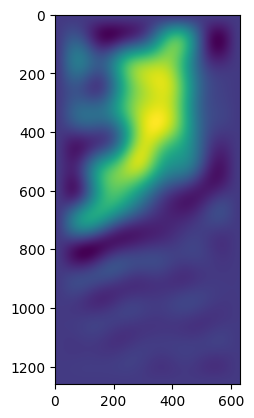

In [273]:
plt.imshow(sol[400])

In [274]:
# sound at the middle

